In [649]:
import pandas as pd
import numpy as np
import re, os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
jet = plt.get_cmap('jet')


import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.regression.linear_model import WLS
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.discrete.discrete_model import Probit
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import norm
import seaborn as sns
from scipy.stats import chisquare
from statsmodels.discrete.discrete_model import Poisson

import itertools
data_path = "C:/Users/SpiffyApple/Documents/USC/OwnResearch/proposal"

In [3]:
#convenience function
def toLatex(tmpDF, file_name, regOut = False):
    if regOut == False:
        with open("/".join([data_path,'output',file_name]), 'w+') as f:
            f.write(tmpDF.to_latex())
    if regOut:
        with open("/".join([data_path,'output',file_name]), 'w+') as f:
            f.write(tmpDF.as_latex())
    return(tmpDF)

def toExcel(tmpDF, file_name):
    tmpDF.to_excel("/".join([data_path,'output',file_name]))
    return(tmpDF)

# AHS Data

The data come from [here](https://www.census.gov/programs-surveys/ahs/data/2015/ahs-2015-public-use-file--puf-/2015-ahs-metropolitan-puf-microdata.html). Important AHS data documentation [here](https://www.census.gov/content/dam/Census/programs-surveys/ahs/tech-documentation/2015/Getting%20Started%20with%20the%20AHS%20PUF.pdf), variable [labels](https://www.census.gov/data-tools/demo/codebook/ahs/ahsdict.html?s_appName=ahsdict&s_year=2015)

Other years include:, [2017]()
[2013](https://www.census.gov/programs-surveys/ahs/data/2013/ahs-2013-public-use-file--puf-/ahs-2013-national-public-use-file--puf-.html), and 
[2011](https://www.census.gov/programs-surveys/ahs/data/2011/ahs-national-and-metropolitan-puf-microdata.html)

Another useful link is the [QuickFacts](https://www.census.gov/quickfacts/fact/table/milwaukeecitywisconsin/PST045217) for Milwaukee which gives basic information on housing and demographics

**Data are prepped in the AHS data 2015 preparation** notebook. The results are uploaded here for expediency

In [310]:
## load prepped data
df = pd.read_csv("/".join([data_path, 'AHS2015prepped_ver2.csv']),low_memory=False)

In [311]:
## labels for columns
ahsdict = pd.read_csv("/".join([data_path, 'AHSDICT_28AUG18_23_35_13_43_S.csv']))
#drop unnecessary columns
ahsdict.drop(['Disclosure','Variable_Number','INUNIVERSE','Topic_Number','Present_in_Survey_Years','Topic_Subtopic_ID','Imputation_Strategy','Question','Instrument_Variable_Name','Survey Year','Subtopic'],axis=1,inplace=True)
ahsdict.set_index('Variable',inplace=True)

In [312]:
## create a convenience function for variable look up
def varlu(s):
    return(ahsdict[ahsdict.Description.str.lower().str.contains(s)])

In [ ]:
## simpify race
df.loc[df.HHRACE.str.contains("Alaska"),'HHRACE'] = 'indigenous'

In [493]:
Milwaukee = df.loc[df.cbsatitle.str.contains('Milwaukee') & (df.renter==1)].copy()

In [494]:
Milwaukee.shape

(915, 308)

# What do renters rent? 

In [394]:
cols = ['BEDROOMS','BATHROOMS','DINING','TOTROOMS','UNITFLOORS','STORIES', 'RENT','TENURE']
Milwaukee[cols].describe(percentiles=[.025,.25,.5,.75,.975]).drop(['std','count']).round(1)

,BEDROOMS,DINING,TOTROOMS,UNITFLOORS,STORIES,RENT
mean,2.0,0.3,4.4,2.5,2.9,788.7
min,0.0,0.0,1.0,1.0,1.0,4.0
2.5%,1.0,0.0,2.0,1.0,1.0,120.0
25%,1.0,0.0,4.0,2.0,2.0,580.0
50%,2.0,0.0,4.0,3.0,3.0,710.0
75%,2.0,1.0,5.0,3.0,3.0,930.0
97.5%,4.0,1.0,7.0,3.0,7.0,2600.0
max,5.0,2.0,9.0,3.0,7.0,2600.0


In [455]:
cols = ['YRBUILT','UNITSIZE','BLD']
Milwaukee.loc[:,'UNITSIZE'] = Milwaukee.UNITSIZE.str.replace("square feet", 'sqrft').str.replace(" to ",'-').str.replace(",",'')
countDict={}
for c in cols:
    tmp = Milwaukee.groupby(c).RENT.count() #.sort_values(ascending=False)
    countDict[c] = pd.concat([tmp,(tmp/tmp.sum()).round(2)],axis=1, keys=['count','share'])

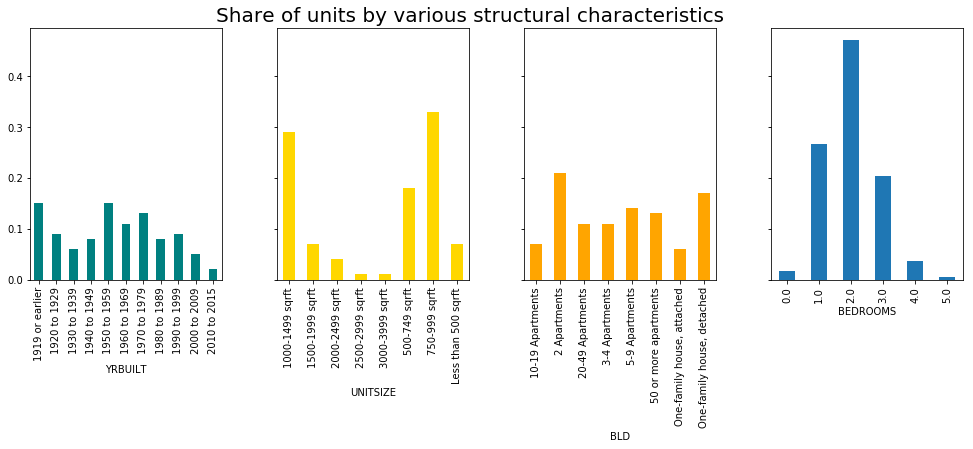

In [466]:
fig, axes = plt.subplots(1,4, sharey=True) 

for key, ax, color in zip(countDict.keys(),axes.flatten(),['teal','gold','orange']):
    countDict[key].share.plot(ax=ax, kind='bar',color = color)
    #ax.set_title("Share of units by %s" %key,fontsize = 18)
    
fig.tight_layout()
fig.suptitle("Share of units by various structural characteristics", fontsize=20)    
fig.set_figwidth(15)
fig.set_figheight(10)

(Milwaukee.groupby("BEDROOMS").RENT.count()/Milwaukee.groupby("BEDROOMS").RENT.count().sum()).plot(kind='bar', ax=axes[3])

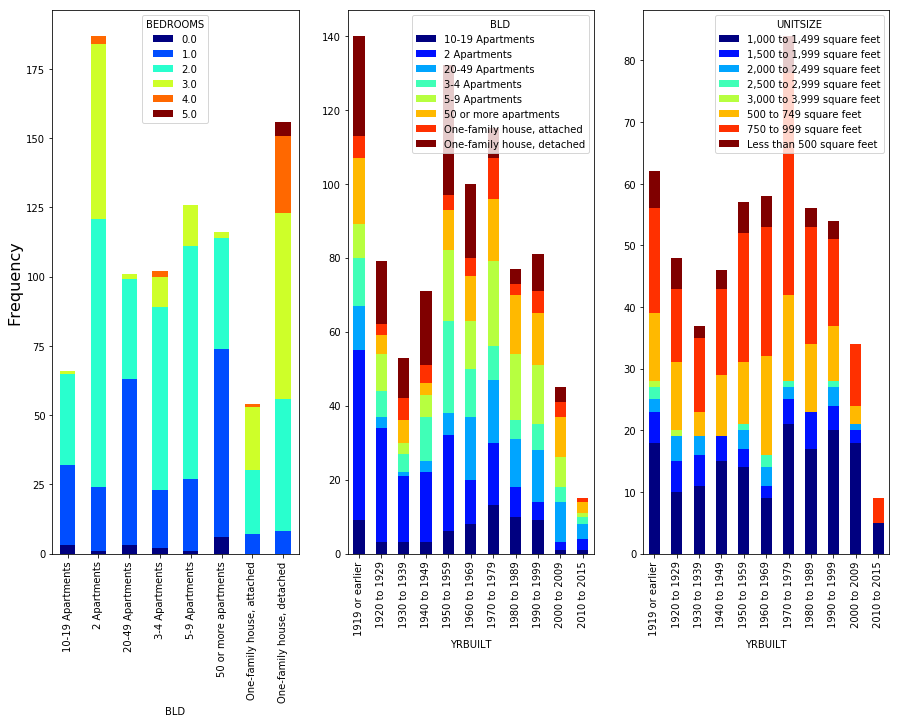

In [550]:
fig, ax = plt.subplots(1,3)

Milwaukee.groupby(['BLD','BEDROOMS']).RENT.count().unstack().replace(np.nan, 0).plot(kind='bar', stacked=True, ax=ax[0], colormap='jet')

#Milwaukee.groupby(['UNITFLOORS','BEDROOMS']).RENT.count().unstack().replace(np.nan, 0).plot(kind='bar', stacked=True,ax=ax[1], colormap='jet')

Milwaukee.groupby(['YRBUILT','BLD']).RENT.count().unstack().replace(np.nan, 0).plot(kind='bar', stacked=True,ax=ax[1], colormap='jet')

Milwaukee.groupby(['YRBUILT','UNITSIZE']).RENT.count().unstack().replace(np.nan, 0).plot(kind='bar', stacked=True,ax=ax[2], colormap='jet')


ax[0].set_ylabel("Frequency",fontsize=16)
fig.set_figwidth(15)
fig.set_figheight(10)

In [551]:
Milwaukee.groupby(['YRBUILT','BLD']).RENT.count().unstack()

BLD,10-19 Apartments,2 Apartments,20-49 Apartments,3-4 Apartments,5-9 Apartments,50 or more apartments,"One-family house, attached","One-family house, detached"
YRBUILT,,,,,,,,
1919 or earlier,9.0,46.0,12.0,13.0,9.0,18.0,6.0,27.0
1920 to 1929,3.0,31.0,3.0,7.0,10.0,5.0,3.0,17.0
1930 to 1939,3.0,18.0,1.0,5.0,3.0,6.0,6.0,11.0
1940 to 1949,3.0,19.0,3.0,12.0,6.0,3.0,5.0,20.0
1950 to 1959,6.0,26.0,6.0,25.0,19.0,11.0,4.0,35.0
1960 to 1969,8.0,12.0,17.0,13.0,13.0,12.0,5.0,20.0
1970 to 1979,13.0,17.0,17.0,9.0,23.0,17.0,11.0,8.0
1980 to 1989,10.0,8.0,13.0,5.0,18.0,16.0,3.0,4.0
1990 to 1999,9.0,5.0,14.0,7.0,16.0,14.0,6.0,10.0


# Who Rents?

In [99]:
print("Share of Milwaukee that rents: %.2f%%" %(Milwaukee.renter.sum()/Milwaukee.shape[0]))

Share of Milwaukee that rents: 0.39%


In [397]:
Milwaukee.loc[:,'NUMKIDS'] = Milwaukee.NUMPEOPLE - Milwaukee.NUMADULTS
Milwaukee.loc[:,'people_per_room'] = Milwaukee.NUMPEOPLE/Milwaukee.TOTROOMS

In [398]:
cols = ['HHAGE','HINCP','NUMPEOPLE','NUMADULTS', 'people_per_room']
Milwaukee[cols].describe().drop(['std','count']).round(2)

,HHAGE,HINCP,NUMPEOPLE,NUMADULTS,people_per_room
mean,45.56,41016.8,2.1,1.56,0.48
min,18.00,0.0,1.0,1.00,0.11
25%,30.00,16250.0,1.0,1.00,0.33
50%,42.00,30700.0,2.0,1.00,0.40
75%,59.00,56050.0,3.0,2.00,0.60
max,85.00,381500.0,8.0,5.00,1.60


In [399]:
## format education variable
Milwaukee.loc[:,'HHGRAD'] = Milwaukee.HHGRAD.str.replace("[\:\-\/''\x92]",'').str.replace("\([\w\s,?]+\)",'').str.strip()

In [400]:
Milwaukee.loc[:,'schooling'] = 'HS graduate'
Milwaukee.loc[Milwaukee.HHGRAD.str.contains("Masters|Doctorate"),'schooling'] = 'post-bachelors'
Milwaukee.loc[Milwaukee.HHGRAD.str.contains("Bachelor"),'schooling'] = 'post-college'
Milwaukee.loc[Milwaukee.HHGRAD.str.contains("Associate|Some|Professional|Vocational"),'schooling'] = 'beyond HS'
Milwaukee.loc[Milwaukee.HHGRAD.str.contains("1,5,7,11,12,"),'schooling'] = 'no HS'

In [477]:
cols = ['HHRACE','HHSEX','schooling','PARTNER','HHCITSHP']

countDict={}
for c in cols:
    tmp = Milwaukee.groupby(c).RENT.count().sort_values(ascending=False)
    countDict[c] = pd.concat([tmp,(tmp/tmp.sum()).round(2)],axis=1, keys=['count','share'])

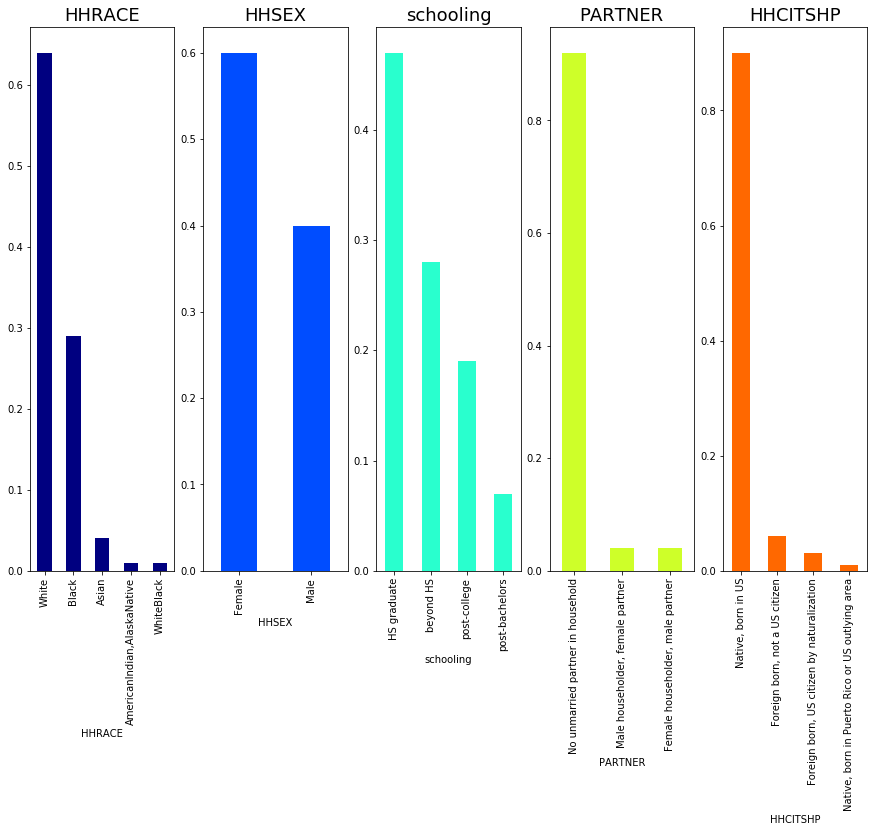

In [478]:
fig, axes = plt.subplots(1,5)
palette = iter(plt.cm.jet(np.linspace(0,1,6)))

for key, ax, color in zip(countDict.keys(),axes.flatten(), palette):
    countDict[key][countDict[key].share>0].share.plot(ax=ax, kind='bar', color=color)
    ax.set_title("%s" %key,fontsize = 18)
    
fig.set_figwidth(15)
fig.set_figheight(10)